<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Visión por Computadora</center></span>
## <span style="color:red"><center>Transfer Learning</center></span>

##   <span style="color:blue">Profesores</span>

### Coordinador


- Campo Elías Pardo Turriago, cepardot@unal.edu.co 

### Conferencistas


- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

## <span style="color:blue">Asesora Medios y Marketing digital</span>

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 



## <span style="color:blue">Asistentes</span>



- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

## <span style="color:blue">Introducción</span>

Hemos visto cómo el usar modelos pre entrenados puede dar resultados más que decentes al trabajar con datos de nuestras propias tareas, pero todavía nos encontramos con ciertos percances. Lo más sensato para arreglar esto sería no usar modelos pre entrenados y entrenar estas arquitecturas desde el inicio con nuestros propios datos, pero corremos con las limitaciones de nuestros equipos, y el tamaño de la base de datos personal, que más que probablemente sería mucho menor a con la que se entrenaron los modelos pre hechos


Pero. ¿Qué tal si pudieramos acoplar estos modelos ya entrenados y funcionales a nuestro caso específico? Este es el conocido Aprendizaje por transferencia o "Transfer Learning"  

## <span style="color:blue">Preeliminares</span>

Las redes neuronales modernas que vienen en varios de los paquetes que trabajamos son muy poderosos. Esto es debido a que son entrenadas con bases de datos de enorme cantidad y variedad. Es posible utilizar estos modelos ya entrenados para tareas específicas personales, y servirán, pero al final de día dichos modelos fueron optimizados con otras intenciones, por ejemplo para solucionar la clasificación de la base de datos ["ImageNet"](https://www.image-net.org/).

<figure>
<center>
<img src="../Imagenes/Imagenet.png" width="600" height="300" align="center"/> 
</center>
</figure>

En este caso podríamos tal vez decir que estos modelos son "demasiado generalizados", por lo que no son perfectos a la hora de trabajar en proyectos más humildes o especializados.

Pero este no es el fin del mundo. Gracias a esa generalización que tienen, estos modelos son expertos en obtener información importante de las imágenes. El problema es en el momento de la clasificación.

## <span style="color:blue">Proceso</span>

<figure>
<center>
<img src="../Imagenes/transfer_learning_general.png" width="900" height="600" align="center"/> 
</center>
</figure>

Sabemos que, en los casos clásicos, las redes convolucionales tienen dos partes:

- **Sección convolucional**: Donde se procesan las imágenes para obtener las características esenciales y pasarlas al idioma de las computadoras
- **Sección completamente conectada**: Se usa la información de la anterior sección para hacer una tarea de clasificación,regresión, etc 

La sección convolucional la podemos conservar tal y como está, mientras que la sección completamente conectada podemos quitar la última capa, o incluso la capa completa, y hacer un reemplazo con una capa(o capas) que se ajusten a la tarea de clasificación que necesitamos.

Esta nueva capa tiene pesos aleatorios, pero no buscamos que el modelo completo lo sea. En su lugar, toda la sección que no removimos debe mantener los pesos originales. El reto entonces es entrenar la red de tal forma que consigamos los pesos las nuevas capas, pero manteniendo las del resto de la red. Así aprovecharemos las capacidades de generalización de las redes pre entrenadas, y las dirigiremos nuestras tareas.

Por supuesto, no podemos empezar el entrenamiento desde las capas con peso aleatorio. Las imágenes tienen que pasar por la red completa. Si lo hacemos así como así, los pesos de toda la arquitectura cambiarán. Esto se resuelve de una forma muy sencilla: Le decimos al optimizador que no actualice sino hasta esas últimas capas. Este proceso se llama "congelar" la red.

<figure>
<center>
<img src="../Imagenes/transfer_learning_general.svg" width="600" height="300" align="center"/> 
</center>
</figure>



Vamos a elegir una red a la cual hacer los cambios y haremos un par de proyectos para aplicarlo

## <span style="color:blue">VGG16</span>

La red neuronal que vamos a usar. Esta en efecto fue creada para la competencia de ImageNet en 2014, la cual ganó logrando un 92.7% de precisión. Esta tiene en su totalidad 16 capas y aproximadamente 138 millones de parámetros.

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as functional
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Cargamos el modelo. Diciendo que queremos sus pesos

In [2]:
model = models.vgg16(pretrained=True).to(device)

Veamos un poco más a fondo su estructura

In [3]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Como dijimos, esta red está hecha para detectar miles de objetos distintos y fue entrenada para esto mismo. Pero claro, esa no es nuestra misión, ahora solo nos vamos a enfocar en dos tareas "sencillas"

## <span style="color:blue">Horse or Human</span>

Este dataset contiene imagenes generadas digitalmente de tamaño 300x300 a color. tiene 500 renderizaciones de diferentes especies de caballos, y 527 renderizaciones de humanos en distintas poses. 
procederemos a descargarlo

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /mnt/storage/Datasets/horse-or-human/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /mnt/storage/Datasets/horse-or-human/validation-horse-or-human.zip

--2022-03-25 21:20:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.78.176, 172.217.28.112, 172.217.30.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.78.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/mnt/storage/Datasets/horse-or-human/horse-or-human.zip’

/mnt/storage/Datase 100%[===================>] 142.65M  10.4MB/s    in 13s     

2022-03-25 21:20:39 (10.6 MB/s) - ‘/mnt/storage/Datasets/horse-or-human/horse-or-human.zip’ saved [149574867/149574867]

--2022-03-25 21:20:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.30.208, 172.217.173.48, 142.250.78.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.30.208|:443... conn

Los descargamos, pero necesitamos descomprimirlos, y no podemos confiar en la API de tensorflow en este caso.

In [5]:
import os
import zipfile

local_zip = '/mnt/storage/Datasets/horse-or-human/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/mnt/storage/Datasets/horse-or-human/train')
zip_ref.close()
local_zip = '/mnt/storage/Datasets/horse-or-human/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip)
zip_ref.extractall('/mnt/storage/Datasets/horse-or-human/validation')
zip_ref.close()

con los datos descargados podemos crear los dataloaders

In [6]:
train_data_dir = '/mnt/storage/Datasets/horse-or-human/train/'
validation_data_dir = '/mnt/storage/Datasets/horse-or-human/validation/'

loader = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_data = datasets.ImageFolder(train_data_dir, transform=loader)
validation_data = datasets.ImageFolder(validation_data_dir, transform=loader)

train_loader = DataLoader(train_data, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

(32, 3, 224, 224)
(20, 224, 224)


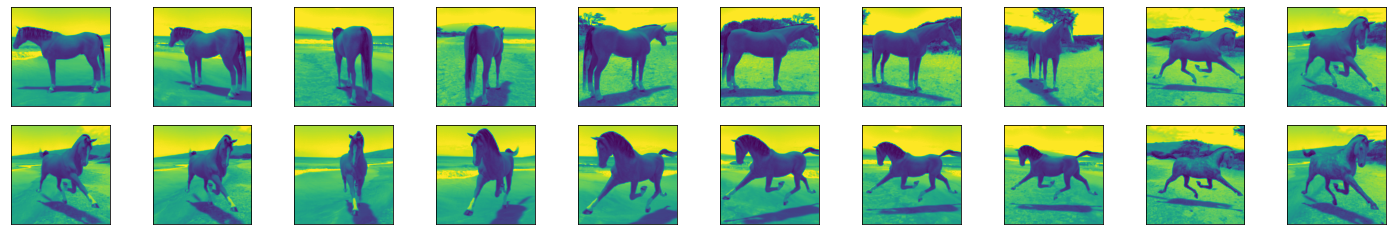

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
# Se obtiene un lote de datos
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)
images = images[12:,2,:,:]
print(images.shape)
# se grafican los elementos en el lote
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))


In [8]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, loss_fn, optimizer = get_model()

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [11]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [12]:
train_losses, train_accuracies = [], []
val_accuracies = []
num_epoch = 5

for epoch in range(num_epoch):
    print(f'epoch {epoch+1}/{num_epoch}')
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        x = x.to(device)
        y = y.reshape((-1,1)).to(torch.float32).to(device)
        
        batch_loss = train_batch(x, y, model, optimizer,
                                 loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f'perdida: {train_epoch_loss}')
    
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        x = x.to(device)
        y = y.reshape((-1,1)).to(torch.float32).to(device)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f'precisión: {train_epoch_accuracy}')
    
    for ix, batch in enumerate(iter(validation_loader)):
        x, y = batch
        x = x.to(device)
        y = y.reshape((-1,1)).to(torch.float32).to(device)
        is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print(f'precisión de validación: {val_epoch_accuracy}')
    
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
        

epoch 1/5
perdida: 1.1279813011783655
precisión: 0.98539435248296
precisión de validación: 0.98828125
epoch 2/5
perdida: 0.6685173854683385
precisión: 0.9931840311587147
precisión de validación: 1.0
epoch 3/5
perdida: 0.49170443054401514
precisión: 0.9980525803310614
precisión de validación: 1.0
epoch 4/5
perdida: 0.33411150256341154
precisión: 0.9980525803310614
precisión de validación: 0.99609375
epoch 5/5
perdida: 0.19362366312380994
precisión: 0.9951314508276533
precisión de validación: 0.99609375


/tmp/ipykernel_127463/3572508330.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


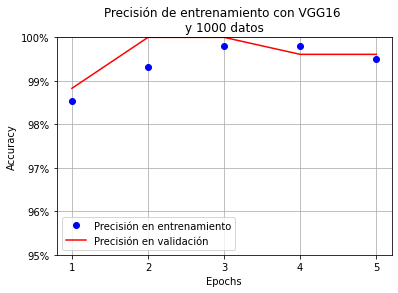

In [13]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Precisión en entrenamiento')
plt.plot(epochs, val_accuracies, 'r', label='Precisión en validación')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Precisión de entrenamiento con VGG16 \ny 1000 datos')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()